# Trabajo Práctico Nro. 2
## Mineria de Datos 2024

### Integrantes:
 * Pace, Bruno. Legajo: P-5295/7.
 * Sancho Almenar, Mariano. Legajo: S-5778/9.

In [1]:
#Manejo de datos
import pandas as pd
import numpy as np

#Gráficos
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz

#Modelado
#!pip install kneed
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
# from sklearn import decomposition
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE, Isomap
# from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# from scipy.sparse import csr_matrix
# from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import classification_report
# from scipy.stats import gaussian_kde
# import scipy.cluster.hierarchy as sch
# import matplotlib.pyplot as plt
# from kneed import KneeLocator
# import seaborn as sns



#Manejo de warnings
import warnings
warnings.filterwarnings('ignore')


### Lectura df

In [2]:
df_companies: pd.DataFrame = pd.read_csv('data/1000_Companies.csv')
df_pokemon: pd.DataFrame = pd.read_csv('data/PokemonDBCart.csv')

# **df_companies**


## Pre procesado *df_companies*

Sobre el dataframe se utilizará un arbol de decisión por regresión.


- EDA.
- Visualizaciones.
- Tratamiento de outliers.
- Normalización.

In [3]:
df_companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RyD_Spend       1000 non-null   float64
 1   Administration  1000 non-null   float64
 2   MarketingSpend  1000 non-null   float64
 3   State           1000 non-null   object 
 4   Profit          1000 non-null   float64
dtypes: float64(4), object(1)
memory usage: 39.2+ KB


In [4]:
df_companies.sample(10)

,RyD_Spend,Administration,MarketingSpend,State,Profit
124,1269.0,110644.5073,71227.57814,New York,50116.99489
160,63354.0,119813.5029,191020.75520,Florida,103155.67470
272,109716.0,126660.4543,280476.36080,Florida,142762.33120
885,138565.0,130921.0060,336140.58510,California,167407.78300
495,146341.0,132069.4011,351144.39830,New York,174050.75270
449,27745.0,114554.6036,122313.09240,Florida,72735.21323
641,58228.0,119056.4719,181130.12420,Florida,98776.57709
810,121583.0,128413.0269,303373.76970,New York,152900.20690
954,94359.0,124392.4625,250844.98740,Florida,129642.97860
804,107501.0,126333.3330,276202.51220,California,140870.07580


Queremos saber si en la columna RyD_Spend hay decimales que no sean 0.

In [5]:
def check_decimals(x: float) -> bool:
    """
    Función auxiliar para determinar si un numero tiene o no parte decimal mayor a 0.
    """
    decimals = x - int(x)
    return decimals != 0

In [6]:
df_companies['decimals_ryd_spend'] = df_companies['RyD_Spend'].apply(check_decimals)

In [7]:
df_companies['decimals_ryd_spend'].value_counts()

decimals_ryd_spend
False    949
True      51
Name: count, dtype: int64

Comprobamos lo que queríamos, por ende ya esta columna no es necesaria. Decidimos dropearla.

In [8]:
df_companies = df_companies.drop('decimals_ryd_spend', axis=1)

Chequeamos que las columnas que quedaron son las originales.

In [9]:
df_companies.columns

Index(['RyD_Spend', 'Administration', 'MarketingSpend', 'State', 'Profit'], dtype='object')

Efectivamente sí hay decimales en esa columna.

In [10]:
df_companies.describe()

,RyD_Spend,Administration,MarketingSpend,Profit
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,81668.927200,122963.897612,226205.058419,119546.164656
std,46537.567891,12613.927535,91578.393542,42888.633848
min,0.000000,51283.140000,0.000000,14681.400000
25%,43084.500000,116640.684850,150969.584600,85943.198543
50%,79936.000000,122421.612150,224517.887350,117641.466300
75%,124565.500000,129139.118000,308189.808525,155577.107425
max,165349.200000,321652.140000,471784.100000,476485.430000


Vemos que hay demasiados decimales que no aportan información extra. Por simplicidad y prolijidad, redondeamos a dos decimales las columnas numericas de tipo float.

In [11]:
df_companies[['RyD_Spend','Administration','MarketingSpend', 'Profit']] = df_companies[
    ['RyD_Spend','Administration','MarketingSpend', 'Profit']].apply(lambda x: round(x,2))

In [12]:
df_companies.isna().sum()

RyD_Spend         0
Administration    0
MarketingSpend    0
State             0
Profit            0
dtype: int64

No hay valores faltantes, por ende, continuamos con el análisis.

### Visualizaciones

In [13]:
px.box(df_companies[
    ['RyD_Spend','Administration','MarketingSpend', 'Profit']], 
    title='Boxplot de las variables de compañias')

Observamos que hay potenciales outliers en las columnas Administration y Profit. Más adelante lo chequeamos.

In [14]:
px.histogram(
    df_companies[['RyD_Spend','Administration','MarketingSpend', 'Profit']],
    title = 'Distribuciones de las variables'
)

- Administration tiene una distribución normal

In [15]:
df_companies[['Administration', 'Profit']].describe()

,Administration,Profit
count,1000.000000,1000.000000
mean,122963.897650,119546.164700
std,12613.927637,42888.633878
min,51283.140000,14681.400000
25%,116640.685000,85943.200000
50%,122421.610000,117641.465000
75%,129139.117500,155577.107500
max,321652.140000,476485.430000


In [16]:
administration_quantile_99: float = df_companies['Administration'].quantile(.99)
administration_quantile_01: float = df_companies['Administration'].quantile(.01)
profit_quantile_99: float = df_companies['Profit'].quantile(.99)

print(f'El cuantil 0.99 de Administration es: {round(administration_quantile_99,2)}')
print(f'El cuantil 0.01 de Administration: {round(administration_quantile_01,2)}')
print(f'El cuantil 0.99 de Profit es: {round(profit_quantile_99,2)}')

El cuantil 0.99 de Administration es: 152705.22
El cuantil 0.01 de Administration: 99809.38
El cuantil 0.99 de Profit es: 185033.03


In [17]:
df_companies_outliers: pd.DataFrame = df_companies.loc[
    (df_companies['Administration'] > administration_quantile_99) |
    (df_companies['Administration'] < administration_quantile_01) |
    (df_companies['Profit'] > profit_quantile_99)
]

print(df_companies_outliers.info())

df_companies_outliers

<class 'pandas.core.frame.DataFrame'>
Index: 27 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RyD_Spend       27 non-null     float64
 1   Administration  27 non-null     float64
 2   MarketingSpend  27 non-null     float64
 3   State           27 non-null     object 
 4   Profit          27 non-null     float64
dtypes: float64(4), object(1)
memory usage: 1.3+ KB
None


,RyD_Spend,Administration,MarketingSpend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
4,142107.34,91391.77,366168.42,Florida,166187.94
11,100671.96,91790.61,249744.55,California,144259.40
14,119943.24,156547.42,256512.92,Florida,132602.65
19,86419.70,153514.11,0.00,New York,122776.86
21,78389.47,153773.43,299737.29,New York,111313.02
24,77044.01,99281.34,140574.81,New York,108552.04
28,66051.52,182645.56,118148.20,Florida,103282.38


Los potenciales outliers son sólo 27 casos. Previo a adoptar una estrategia se realiza su scatterplot.

In [18]:
fig2 = px.scatter(df_companies_outliers.drop(columns=['State']), title='Variables en función de sus índices.')
fig2.show()

La variable **MarketingSpend** posee outliers que son anteriores al índice 957. Se considera desde el index 958 en adelante que las ganancias obtenidas son producto de una buena estrategia adoptada por la empresa.

Al evaluar la variable **Administration**, se observa que si bien hay valores por encima del quantile 0.99 y por debajo del quantil 0.01, no están desfasados de los demás gastos/ganancias. 

La estrategia a adoptar, considerando la poca cantidad de datos outliers, es cambiarlos por la mediana.

In [19]:
# extracción de índices.
outliers_index: list[int] = df_companies_outliers.index[df_companies_outliers.index < 958].tolist() 

df_companies_filtered: pd.DataFrame = df_companies.copy()

# imputación.
df_companies_filtered['MarketingSpend'].loc[
    outliers_index
] = df_companies_filtered['MarketingSpend'].median()

In [20]:
# chequeo imputación.
df_companies_filtered.loc[outliers_index] 

,RyD_Spend,Administration,MarketingSpend,State,Profit
0,165349.20,136897.80,224517.89,New York,192261.83
1,162597.70,151377.59,224517.89,California,191792.06
2,153441.51,101145.55,224517.89,Florida,191050.39
4,142107.34,91391.77,224517.89,Florida,166187.94
11,100671.96,91790.61,224517.89,California,144259.40
14,119943.24,156547.42,224517.89,Florida,132602.65
19,86419.70,153514.11,224517.89,New York,122776.86
21,78389.47,153773.43,224517.89,New York,111313.02
24,77044.01,99281.34,224517.89,New York,108552.04
28,66051.52,182645.56,224517.89,Florida,103282.38


In [21]:
corr_matrix = df_companies_filtered[
    ['RyD_Spend','Administration','MarketingSpend', 'Profit']].corr()
px.imshow(corr_matrix,
          text_auto=True,
          aspect='auto',
          zmin=-1,
          zmax=1, title= 'Matriz de Correlación')

Vemos correlaciones fuertes:
 - Profit - MarketingSpend.
 - Profit - RyD_Spend.
 - MarketingSpend - RyDSpend.

 Hay una correlación que no es particularmente fuerte pero que es de destacar:
 - Profit - Administration.

 Analizando esto con el contexto que tenemos de las ganancias de las empresas con respecto a los gastos de Marketing y Desarrollo, no es descabellado pensar que mientras más se inviertan en estas áreas, más reditos económicos podemos conseguir. 
 Vemos una tendencia que a medida que se gasta más en personal de administración, más se gana.

In [22]:
df_companies_filtered['State'].value_counts()

State
California    344
New York      334
Florida       322
Name: count, dtype: int64


## Separación de conjuntos train-test

Se obtiene dos conjuntos train-test para la comparación de resultados

In [23]:
X: pd.DataFrame = df_companies_filtered.drop(columns=['Profit'], axis=1)
y: pd.DataFrame = pd.DataFrame(df_companies_filtered['Profit'], columns=['Profit'])

In [24]:
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X,
    y,
    test_size=0.8,
    random_state=42
)

In [25]:
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X,
    y,
    test_size=0.8,
    random_state=17
)


## Estandarización

Se utiliza el método de Z-score para la estandarización de los conjuntos


### Conjunto 1

In [26]:
X1_train_std = X1_train.drop(columns=['State'])
X1_test_std = X1_test.drop(columns=['State'])
# y1_train_std = y1_train.to_frame()

In [27]:
scaler1_x: StandardScaler = StandardScaler()
scaler1_y: StandardScaler = StandardScaler()

In [28]:
# Fit modelo de estandarización conjunto 1

X1_train_std: pd.DataFrame = pd.DataFrame(scaler1_x.fit_transform(X1_train_std), columns=X1_train_std.columns)
y1_train_std: pd.DataFrame = pd.DataFrame(scaler1_y.fit_transform(y1_train), columns=y1_train.columns)

In [29]:
# Estandarización conjuntos de test

X1_test_std: pd.DataFrame = pd.DataFrame(scaler1_x.transform(X1_test_std), columns=X1_test_std.columns)
y1_test_std: pd.DataFrame = pd.DataFrame(scaler1_y.transform(y1_test), columns=y1_test.columns)

In [30]:
# Se vuelve a agregar al columna categórica a los conjuntos X

# X1_train_std = pd.concat([X1_train_std, X1_train['State']], axis=1)
# X1_test_std = pd.concat([X1_test_std, X1_test['State']], axis=1)


### Conjunto 2

In [31]:
X2_train_std = X2_train.drop(columns=['State'])
X2_test_std = X2_test.drop(columns=['State'])

In [32]:
scaler2_x: StandardScaler = StandardScaler()
scaler2_y: StandardScaler = StandardScaler()

In [33]:
# Fit modelo de estandarización conjunto 1

X2_train_std: pd.DataFrame = pd.DataFrame(scaler2_x.fit_transform(X2_train_std), columns=X2_train_std.columns)
y2_train_std: pd.DataFrame = pd.DataFrame(scaler2_y.fit_transform(y2_train), columns=y2_train.columns)

In [34]:
# Estandarización conjuntos de test

X2_test_std: pd.DataFrame = pd.DataFrame(scaler2_x.transform(X2_test_std), columns=X2_test_std.columns)
y2_test_std: pd.DataFrame = pd.DataFrame(scaler2_y.transform(y2_test), columns=y2_test.columns)

In [35]:
# Se vuelve a agregar al columna categórica a los conjuntos X

# X2_train_std = pd.concat([X2_train_std, X2_train['State']], axis=1)
# X2_test_std = pd.concat([X2_test_std, X2_test['State']], axis=1)


## Modelos: Árboles de decisión (Regresión) 

Para el dataframe de las 1000 companías, se realizarán predicciones para la variable 'Profit' utilizando árboles de decisión por regresión.

En una primera instancia, se compara un modelo base de árbol con uno con parámetros específicos. 


### Modelo base usando los parámetros por defecto

In [36]:
tree_reg_base = DecisionTreeRegressor()

In [37]:
tree_reg_base.fit(X1_train_std, y1_train_std)

DecisionTreeRegressor()

In [38]:
y1_predict = tree_reg_base.predict(X1_test_std)


#### Obtención de métricas

In [39]:
print("Mean Absolute Error (MAE):", mean_absolute_error(y1_test_std, y1_predict))
print("Mean Squared Error (MSE):", mean_squared_error(y1_test_std, y1_predict))
print("R2 Score:", r2_score(y1_test_std, y1_predict))

Mean Absolute Error (MAE): 0.04488211753256623
Mean Squared Error (MSE): 0.15958995474292947
R2 Score: 0.8719062658859333



#### Visualización

Profundidad del árbol: 11
Número de hojas: 200
Número total de nodos: 399


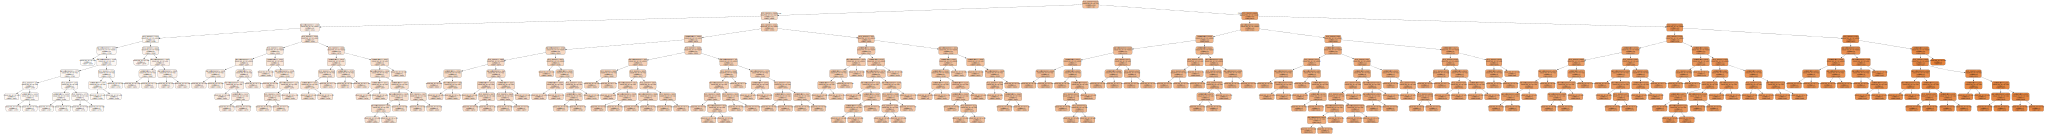

In [40]:
tree = export_graphviz(
        tree_reg_base, 
        out_file=None, 
        feature_names=X1_test_std.columns,
        class_names=y, 
        rounded=True, 
        filled=True)



print(f"Profundidad del árbol: {tree_reg_base.get_depth()}")
print(f"Número de hojas: {tree_reg_base.get_n_leaves()}")
print(f"Número total de nodos: {tree_reg_base.tree_.node_count}")
graphviz.Source(tree)

A partir de las métricas obtenidas y la visualización del árbol, donde se observa una gran cantidad de hojas y profundidad, podemos asumir que el modelo base presenta un **sobreajuste**.

Se realizará una poda del árbol, variando la profundidad, el número  mínimo  de  observaciones,  
el número mínimo de observaciones por separación y  un criterio de separación.

Se compararán los resultados con respecto al modelo base.

In [41]:
# Definir una lista de valores para los parámetros de poda
max_depths = [None, 3, 5, 7, 10]
min_samples_splits = [2, 5, 10]
min_samples_leaves = [1, 2, 5]
criterios = ['squared_error', 'friedman_mse', 'absolute_error'] 
results = []


for max_depth in max_depths:
    for min_samples_split in min_samples_splits:
        for min_samples_leaf in min_samples_leaves:
            for criterio in criterios:
            
                # Crear y entrenar el modelo
                tree_reg = DecisionTreeRegressor(
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    min_samples_leaf=min_samples_leaf,
                    criterion=criterio,
                    random_state=42
                )
                tree_reg.fit(X1_train_std, y1_train_std)
                
                y1_pred = tree_reg.predict(X1_test_std)
                
                # Calcular las métricas de evaluación
                mae = mean_absolute_error(y1_test, y1_pred)
                r2 = r2_score(y1_test, y1_pred)
                
                results.append({
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf,
                    'criterio': criterio,
                    'MAE': mae,
                    'R²': r2
                    })

results_df = pd.DataFrame(results)

# Identificar el mejor modelo basado en la métrica deseada (por ejemplo, R² más alto)
best_model = results_df.loc[results_df['R²'].idxmax()]
print("Mejor modelo encontrado:")
print(best_model)

Mejor modelo encontrado:
max_depth                      3.0
min_samples_split                2
min_samples_leaf                 1
criterio             squared_error
MAE                  119115.636599
R²                       -7.419433
Name: 27, dtype: object



### Mejor modelo para el conjunto 1

Mean Absolute Error (MAE): 0.14912749812991183
Mean Squared Error (MSE): 0.1847629345001132
R2 Score: 0.8517013539848707


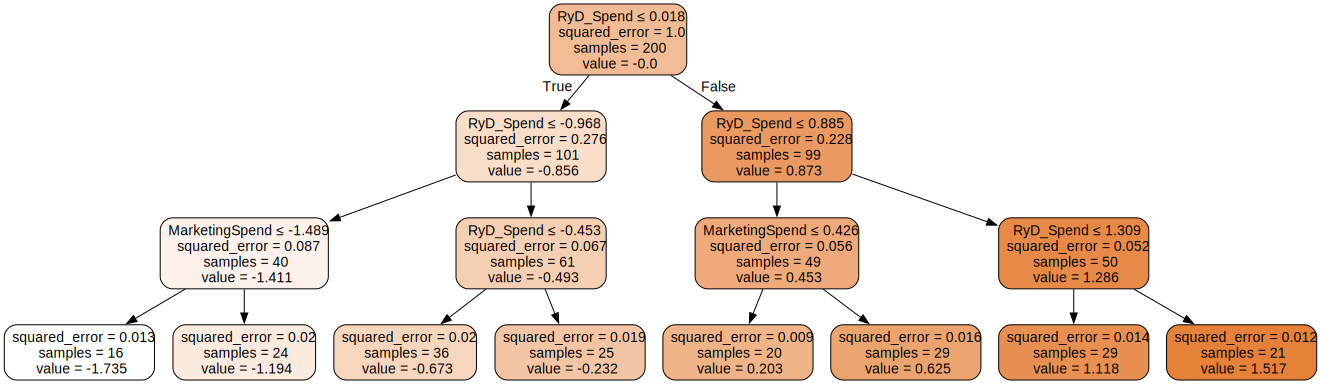

In [42]:
best_tree_reg = DecisionTreeRegressor(
    max_depth=int(best_model['max_depth']),
    min_samples_split=best_model['min_samples_split'],
    min_samples_leaf=best_model['min_samples_leaf'],
    random_state=42
)

best_tree_reg.fit(X1_train_std, y1_train_std)

dot_data = export_graphviz(best_tree_reg, 
                           out_file=None, 
                           feature_names=X1_train_std.columns,
                           filled=True, 
                           rounded=True,  
                           special_characters=True)

best_y1_pred = best_tree_reg.predict(X1_test_std)

# Obtención de la métricas del mejor modelo en el conjunto 1
print("Mean Absolute Error (MAE):", mean_absolute_error(y1_test_std, best_y1_pred))
print("Mean Squared Error (MSE):", mean_squared_error(y1_test_std, best_y1_pred))
print("R2 Score:", r2_score(y1_test_std, best_y1_pred))

graphviz.Source(dot_data)  


### Mejor modelo para el conjunto 2

Mean Absolute Error (MAE): 0.14455939772280757
Mean Squared Error (MSE): 0.13137453928439932
R2 Score: 0.8580189273290793


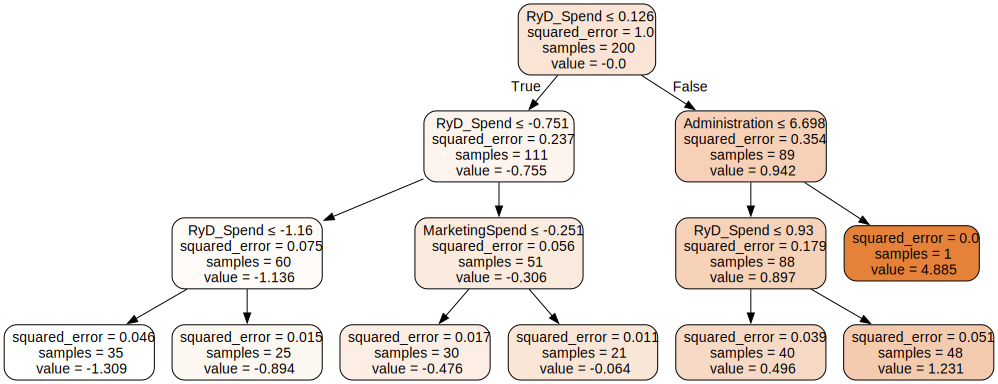

In [43]:
best_tree_reg2 = DecisionTreeRegressor(
    max_depth=int(best_model['max_depth']),
    min_samples_split=best_model['min_samples_split'],
    min_samples_leaf=best_model['min_samples_leaf'],
    random_state=42
)

best_tree_reg2.fit(X2_train_std, y2_train_std)


dot_data = export_graphviz(best_tree_reg2, 
                           out_file=None, 
                           feature_names=X2_train_std.columns,
                           filled=True, 
                           rounded=True,  
                           special_characters=True)

best_y2_pred = best_tree_reg.predict(X2_test_std)

# Obtención de métricas del mejor modelo en el conjunto 2
print("Mean Absolute Error (MAE):", mean_absolute_error(y2_test_std, best_y2_pred))
print("Mean Squared Error (MSE):", mean_squared_error(y2_test_std, best_y2_pred))
print("R2 Score:", r2_score(y2_test_std, best_y2_pred))

graphviz.Source(dot_data)  


# **df_pokemon**

## Pre procesado *df_pokemon*

Sobre el dataframe se utilizará un arbol de decisión por regresión.


- EDA.
- Visualizaciones.
- Tratamiento de outliers.
- Normalización.

Inspección de tipos de datos. Nos encontramos frente a un dataset con 479 datos, lo cual es escaso.

In [44]:
df_pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479 entries, 0 to 478
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Nombre       479 non-null    object
 1   Ataque       479 non-null    int64 
 2   Defensa      479 non-null    int64 
 3   Velocidad    479 non-null    int64 
 4   HP           479 non-null    int64 
 5   SpAtaque     479 non-null    int64 
 6   SpDefensa    479 non-null    int64 
 7   TipoPokemon  479 non-null    object
dtypes: int64(6), object(2)
memory usage: 30.1+ KB


Muestra del dataset.

In [45]:
df_pokemon.sample(5)

,Nombre,Ataque,Defensa,Velocidad,HP,SpAtaque,SpDefensa,TipoPokemon
342,Darumaka,90,45,50,70,15,45,fuego
212,Swablu,40,60,50,45,40,75,normal
332,Swadloon,63,90,42,55,50,80,bicho
233,Regiroca,100,200,50,80,50,100,roca
391,Braixen,59,58,73,59,90,70,fuego


Cantidad de categorias de 'TipoPokemon' para adoptar una estrategia posterior.

In [46]:
df_pokemon.isna().sum()

Nombre         0
Ataque         0
Defensa        0
Velocidad      0
HP             0
SpAtaque       0
SpDefensa      0
TipoPokemon    0
dtype: int64

No hay datos faltantes.

In [47]:
df_pokemon['TipoPokemon'].value_counts()

TipoPokemon
agua         80
hierba       78
bicho        72
normal       60
psiquico     53
fuego        52
roca         45
electrico    39
Name: count, dtype: int64

In [48]:
px.box(df_pokemon[['Ataque','Defensa','Velocidad','HP','SpAtaque','SpDefensa']], title='Boxplot de las variables')

Se evalúa que de forma potencial todas las variables tienen outliers. 

In [49]:
df_pokemon_outliers = df_pokemon.loc[
    (df_pokemon['Ataque'] > df_pokemon['Ataque'].quantile(0.99)) |
    (df_pokemon['Defensa'] > df_pokemon['Defensa'].quantile(0.99)) |
    (df_pokemon['Velocidad'] > df_pokemon['Velocidad'].quantile(0.99)) |
    ((df_pokemon['HP'] > df_pokemon['HP'].quantile(0.99)) | (df_pokemon['HP'] < df_pokemon['HP'].quantile(0.01))) |
    (df_pokemon['SpAtaque'] > df_pokemon['SpAtaque'].quantile(0.99)) |
    (df_pokemon['SpDefensa'] > df_pokemon['SpDefensa'].quantile(0.99))
]

print(df_pokemon_outliers.info())

df_pokemon_outliers

<class 'pandas.core.frame.DataFrame'>
Index: 28 entries, 38 to 477
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Nombre       28 non-null     object
 1   Ataque       28 non-null     int64 
 2   Defensa      28 non-null     int64 
 3   Velocidad    28 non-null     int64 
 4   HP           28 non-null     int64 
 5   SpAtaque     28 non-null     int64 
 6   SpDefensa    28 non-null     int64 
 7   TipoPokemon  28 non-null     object
dtypes: int64(6), object(2)
memory usage: 2.0+ KB
None


,Nombre,Ataque,Defensa,Velocidad,HP,SpAtaque,SpDefensa,TipoPokemon
38,Alakazam,50,65,150,55,175,105,psiquico
57,Onix,45,160,70,35,30,45,roca
89,Mewtwo,150,70,140,106,194,120,psiquico
108,Pichu,40,15,60,20,35,35,electrico
127,Wobbuffet,33,58,33,190,33,58,psiquico
132,Shuckle,10,230,5,20,10,230,bicho
133,Heracross,185,115,75,80,40,105,bicho
145,Blissey,10,10,55,255,75,135,normal
151,Tyranitar,164,150,71,100,95,120,roca
152,Lugia,90,130,110,106,90,154,psiquico


Se observa que dado que el total de los datos son 479 y que los 28 outliers representan un 5.84% del total, se procede a imputar por la media. Se intenta conservar la mayor integridad y representatividad de los datos.

In [50]:
numerical_columns: list[str] = ['Ataque', 'Defensa', 'Velocidad', 'HP', 'SpAtaque', 'SpDefensa'] # lista de columnas para iterar

Seteo las columans a nan para imputar facilmente.

In [51]:
for column in numerical_columns:
    df_pokemon_outliers[column] = np.nan #seteo cada columna a valores nan

df_pokemon_outliers

,Nombre,Ataque,Defensa,Velocidad,HP,SpAtaque,SpDefensa,TipoPokemon
38,Alakazam,NaN,NaN,NaN,NaN,NaN,NaN,psiquico
57,Onix,NaN,NaN,NaN,NaN,NaN,NaN,roca
89,Mewtwo,NaN,NaN,NaN,NaN,NaN,NaN,psiquico
108,Pichu,NaN,NaN,NaN,NaN,NaN,NaN,electrico
127,Wobbuffet,NaN,NaN,NaN,NaN,NaN,NaN,psiquico
132,Shuckle,NaN,NaN,NaN,NaN,NaN,NaN,bicho
133,Heracross,NaN,NaN,NaN,NaN,NaN,NaN,bicho
145,Blissey,NaN,NaN,NaN,NaN,NaN,NaN,normal
151,Tyranitar,NaN,NaN,NaN,NaN,NaN,NaN,roca
152,Lugia,NaN,NaN,NaN,NaN,NaN,NaN,psiquico


Chequeo imputación nan.

In [52]:
df_pokemon_outliers[numerical_columns].isna().sum()

Ataque       28
Defensa      28
Velocidad    28
HP           28
SpAtaque     28
SpDefensa    28
dtype: int64

Imputo por la mediana.

In [53]:
df_pokemon_outliers.fillna(df_pokemon[numerical_columns].median(), inplace=True)

In [54]:
df_pokemon_outliers

,Nombre,Ataque,Defensa,Velocidad,HP,SpAtaque,SpDefensa,TipoPokemon
38,Alakazam,70.0,65.0,64.0,65.0,69.0,66.0,psiquico
57,Onix,70.0,65.0,64.0,65.0,69.0,66.0,roca
89,Mewtwo,70.0,65.0,64.0,65.0,69.0,66.0,psiquico
108,Pichu,70.0,65.0,64.0,65.0,69.0,66.0,electrico
127,Wobbuffet,70.0,65.0,64.0,65.0,69.0,66.0,psiquico
132,Shuckle,70.0,65.0,64.0,65.0,69.0,66.0,bicho
133,Heracross,70.0,65.0,64.0,65.0,69.0,66.0,bicho
145,Blissey,70.0,65.0,64.0,65.0,69.0,66.0,normal
151,Tyranitar,70.0,65.0,64.0,65.0,69.0,66.0,roca
152,Lugia,70.0,65.0,64.0,65.0,69.0,66.0,psiquico


In [55]:
list_index: list[int] = df_pokemon_outliers.index.tolist()

In [56]:
df_pokemon_final: pd.DataFrame = df_pokemon.copy()

df_pokemon_final = df_pokemon_final.drop(list_index)

df_pokemon_final = pd.concat([df_pokemon_final, df_pokemon_outliers], join='outer')

In [57]:
df_pokemon_final

,Nombre,Ataque,Defensa,Velocidad,HP,SpAtaque,SpDefensa,TipoPokemon
0,Bulbasaur,49.0,49.0,45.0,45.0,65.0,65.0,hierba
1,Ivysaur,62.0,63.0,60.0,60.0,80.0,80.0,hierba
2,Venusaur,100.0,123.0,80.0,80.0,122.0,120.0,hierba
3,Charmander,52.0,43.0,65.0,39.0,60.0,50.0,fuego
4,Charmeleon,64.0,58.0,80.0,58.0,80.0,65.0,fuego
...,...,...,...,...,...,...,...,...
420,Carbink,70.0,65.0,64.0,65.0,69.0,66.0,roca
422,Hoopa,70.0,65.0,64.0,65.0,69.0,66.0,psiquico
475,Pheromosa,70.0,65.0,64.0,65.0,69.0,66.0,bicho
476,Xurkitree,70.0,65.0,64.0,65.0,69.0,66.0,electrico


Analizo duplicados. Observamos que no existen.

In [58]:
df_pokemon_final.duplicated().sum()

np.int64(0)

## División de datos pokemon
Se divide el dataset en dos pares de conjuntos:
- El primer par en 80% de datos para entrenar el modelo y 20% testo.
- El segundo par en 70% de datos para entrenar el modelo y 30% testeo.  

Defino mi dataset **'y' como las dummies de la columna 'TipoPokemon', producto de realizar one-hot encoder**. Por ende, posee las columnas:  Defino mi
- agua	
- bicho	
- electrico	
- fuego	
- hierba	
- normal	
- psiquico	
- roca   

*El dataset 'X' tiene las columnas restantes:*
- Ataque
- Defensa 
- Velocidad 
- HP 
- SpAtaque 
- SpDefensa 

Se decidió dropear la columna 'Nombre', porque se considera no aportar información relevante.

Defino que mi columna target es 'TipoPokemon'. Como es una columna categórica, tomo las dummies, producto de realizar One-Hot encoder.

In [59]:
X_pokemon = df_pokemon_final.drop(['TipoPokemon', 'Nombre'], axis=1)
y_pokemon = pd.get_dummies(df_pokemon_final['TipoPokemon'], dtype=int)

Separo en dos 4-tuplas de datasets de test y train:
- La primera tiene destinado un 80% de los datos para training y 20% para test.
- La segunda tiene destinado un 70% de los datos para training y 30% para test.

In [60]:
X_train_80, X_test_20, y_train_80, y_test_20 = train_test_split(X_pokemon, y_pokemon, test_size=0.2, random_state=42) 

X_train_70, X_test_30, y_train_70, y_test_30 = train_test_split(X_pokemon, y_pokemon, test_size=0.3, random_state=42)

Aplicamos estandarización para escalar el modelo con Z-Score. Se realiza posterior a la separación para no sesgar los datos de test. 
Los datasets de las variables target no serán estandarizadas ya que son dummies.

In [62]:
X_80: StandardScaler = StandardScaler()
X_70: StandardScaler = StandardScaler()

Se aplica Z-Score con el mismo criterio en ambos casos, evitando sesgos.

In [63]:
X_train_80_std: pd.DataFrame = pd.DataFrame(X_80.fit_transform(X_train_80), columns=X_train_80.columns)

X_test_20_std: pd.DataFrame = pd.DataFrame(X_80.transform(X_test_20), columns=X_test_20.columns)

X_train_70_std: pd.DataFrame = pd.DataFrame(X_70.fit_transform(X_train_70), columns=X_train_70.columns)

X_test_30_std: pd.DataFrame = pd.DataFrame(X_70.transform(X_test_30), columns=X_test_30.columns)